In [3]:
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import names
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.figsize'] = (10, 8)

In [4]:
trump_tweets = pd.DataFrame.from_csv('/Users/gabrielacarrillo/Desktop/CS506/trump_location_filled.csv')
hillary_tweets = pd.DataFrame.from_csv('/Users/gabrielacarrillo/Desktop/CS506/hillary_location_filled.csv')

In [5]:
print(list(trump_tweets))
print(list(hillary_tweets))

['date', 'id', 'text', 'userid', 'loc', 'state', 'lat', 'lon', 'hashtag']
['date', 'id', 'text', 'userid', 'loc', 'state', 'lat', 'lon', 'hashtag']


In [6]:
trump_strings = []
for index, row in trump_tweets.iterrows():
    text = str(row['text'])
    trump_strings.append(text)

In [7]:
hillary_strings = []
for index, row in hillary_tweets.iterrows():
    hillary_strings.append(str(row['text']))

In [8]:
import nltk
def format_sentence(sent):
    return({word: True for word in nltk.word_tokenize(sent)})

In [9]:
hillary_tweets_formatted = []
for tweet in hillary_strings:
    hillary_tweets_formatted.append(format_sentence(tweet))
trump_tweets_formatted = []
for tweet in trump_strings:
    trump_tweets_formatted.append(format_sentence(tweet))

In [10]:
positive_tweets = []
with open("/Users/gabrielacarrillo/Desktop/CS506/twilio-sent-analysis/pos_tweets.txt") as f:
    for i in f: 
        positive_tweets.append([format_sentence(i), 'pos'])

In [11]:
negative_tweets = []
with open("/Users/gabrielacarrillo/Desktop/CS506/twilio-sent-analysis/neg_tweets.txt") as f:
    for i in f: 
        negative_tweets.append([format_sentence(i), 'neg'])

In [12]:
train_data = positive_tweets + negative_tweets
test_data = hillary_tweets_formatted + trump_tweets_formatted
classifier = NaiveBayesClassifier.train(train_data)
classifier.show_most_informative_features()

Most Informative Features
                 awesome = True              pos : neg    =     24.7 : 1.0
                      no = True              neg : pos    =     22.1 : 1.0
                headache = True              neg : pos    =     21.2 : 1.0
               beautiful = True              pos : neg    =     14.2 : 1.0
                   Thank = True              pos : neg    =     14.2 : 1.0
                    love = True              pos : neg    =     14.1 : 1.0
                      Hi = True              pos : neg    =     12.7 : 1.0
                 amazing = True              pos : neg    =     10.3 : 1.0
                    lost = True              neg : pos    =     10.2 : 1.0
                    sick = True              neg : pos    =      9.9 : 1.0


In [13]:
hillary_predicted = []
for tweet in hillary_tweets_formatted:
    hillary_predicted.append(classifier.classify(tweet))

In [14]:
trump_predicted = []
for tweet in trump_tweets_formatted:
    trump_predicted.append(classifier.classify(tweet))

In [15]:
trump_tweets['sentiment'] = trump_predicted
trump_tweets['party'] = 'rep'

In [16]:
hillary_tweets['sentiment'] = hillary_predicted
hillary_tweets['party'] = 'dem'

In [17]:
trump_pos_rows = trump_tweets[trump_tweets['sentiment']=='pos']
trump_neg_rows = trump_tweets[trump_tweets['sentiment']=='neg']
hillary_pos_rows = hillary_tweets[hillary_tweets['sentiment']=='pos']
hillary_neg_rows = hillary_tweets[hillary_tweets['sentiment']=='neg']

In [18]:
print(len(trump_tweets))
print(len(trump_pos_rows))
print(len(hillary_pos_rows))

841777
277745
140676


418421


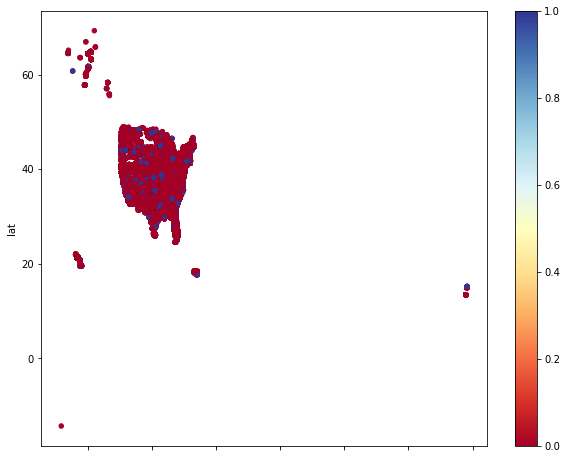

In [20]:
# only positive tweets and k=2 
vectorizer = TfidfVectorizer(stop_words='english')
df = trump_pos_rows.append(hillary_pos_rows)
col = df['party'].map({'rep':'r', 'dem':'b'})
X = vectorizer.fit_transform(df['text'])
model = MiniBatchKMeans(n_clusters=2) # faster kmeans algorithm
model.fit(X)
labels = model.labels_
centers = np.array(model.cluster_centers_)
#for i, l in enumerate(labels):
    #print(i, l)
print(len(labels))
locations = df[['lat', 'lon']]
#my_map = Basemap(projection='merc', resolution='c',
                #llcrnrlat=-15, urcrnrlat=71,
                #llcrnrlon=-180, urcrnrlon=-60)
locations.plot.scatter(x='lon', y='lat', c=labels, cmap='RdYlBu')
#my_map.drawcoastlines()
#my_map.drawcountries()

In [21]:
def kmeans_plot_map_legend(matrix, vectorizer, kmeans, lat_lon_df, num_terms=10):
    '''plot sctter plots for different clustering base on kmeans, but also plot the legends as well
    matrix -- a sparse matrix, after you call fit_transform over all_tweets dataframe
    vectorizer -- the vectorizer you used to do fit_transform on all_tweets
    kmeans : kmeans model, should be already fit
    lat_lon_df : a pandas dataframe containing latitudes and longitudes'''
    my_map = Basemap(projection='merc', resolution='c',
                llcrnrlat=25, urcrnrlat=42,
                llcrnrlon=-125, urcrnrlon=-115)
    
    terms = vectorizer.get_feature_names()
    lons, lats = df.lon.values, df.lat.values
    for k in range(kmeans.n_clusters):
        current_lons = lons[ kmeans.labels_ == k ]
        current_lats = lats[ kmeans.labels_ == k ]
        
        legends = ''
        for count, index in enumerate(np.argsort(-kmeans.cluster_centers_[k]) ):
            if count >= num_terms:
                break
            legends += terms[index] + ', '
        
        x, y = my_map(current_lons, current_lats)
        my_map.scatter(x, y, label=legends)
        
    my_map.drawcoastlines()
    my_map.drawcountries()
    plt.legend()

/Users/gabrielacarrillo/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/gabrielacarrillo/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


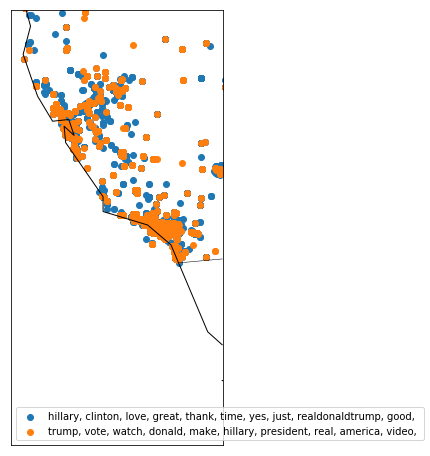

In [22]:
kmeans_plot_map_legend(X, vectorizer, model, df, num_terms=10)

In [23]:
def kmeans_plot_map_legend(matrix, vectorizer, kmeans, lat_lon_df, num_terms=10):
    '''plot sctter plots for different clustering base on kmeans, but also plot the legends as well
    matrix -- a sparse matrix, after you call fit_transform over all_tweets dataframe
    vectorizer -- the vectorizer you used to do fit_transform on all_tweets
    kmeans : kmeans model, should be already fit
    lat_lon_df : a pandas dataframe containing latitudes and longitudes'''
    my_map = Basemap(projection='merc', resolution='c',
                llcrnrlat=25, urcrnrlat=32,
                llcrnrlon=-86, urcrnrlon=-80)
    
    terms = vectorizer.get_feature_names()
    lons, lats = df.lon.values, df.lat.values
    for k in range(kmeans.n_clusters):
        current_lons = lons[ kmeans.labels_ == k ]
        current_lats = lats[ kmeans.labels_ == k ]
        
        legends = ''
        for count, index in enumerate(np.argsort(-kmeans.cluster_centers_[k]) ):
            if count >= num_terms:
                break
            legends += terms[index] + ', '
        
        x, y = my_map(current_lons, current_lats)
        my_map.scatter(x, y, label=legends)
        
    my_map.drawcoastlines()
    my_map.drawcountries()
    plt.legend()

/Users/gabrielacarrillo/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/gabrielacarrillo/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


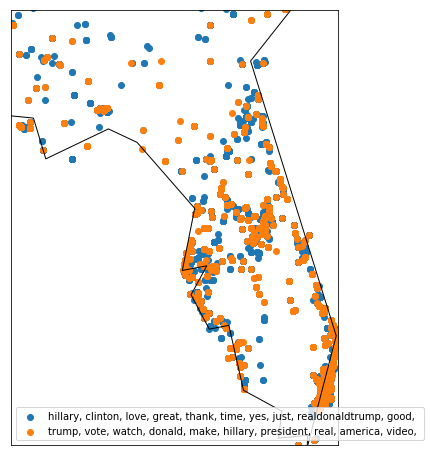

In [24]:
kmeans_plot_map_legend(X, vectorizer, model, df, num_terms=10)

In [25]:
def kmeans_plot_map_legend(matrix, vectorizer, kmeans, lat_lon_df, num_terms=10):
    '''plot sctter plots for different clustering base on kmeans, but also plot the legends as well
    matrix -- a sparse matrix, after you call fit_transform over all_tweets dataframe
    vectorizer -- the vectorizer you used to do fit_transform on all_tweets
    kmeans : kmeans model, should be already fit
    lat_lon_df : a pandas dataframe containing latitudes and longitudes'''
    my_map = Basemap(projection='merc', resolution='c',
                llcrnrlat=40, urcrnrlat=42,
                llcrnrlon=-75, urcrnrlon=-73)
    
    terms = vectorizer.get_feature_names()
    lons, lats = df.lon.values, df.lat.values
    for k in range(kmeans.n_clusters):
        current_lons = lons[ kmeans.labels_ == k ]
        current_lats = lats[ kmeans.labels_ == k ]
        
        legends = ''
        for count, index in enumerate(np.argsort(-kmeans.cluster_centers_[k]) ):
            if count >= num_terms:
                break
            legends += terms[index] + ', '
        
        x, y = my_map(current_lons, current_lats)
        my_map.scatter(x, y, label=legends)
        
    my_map.drawcoastlines()
    my_map.drawcountries()
    plt.legend()

/Users/gabrielacarrillo/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/gabrielacarrillo/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


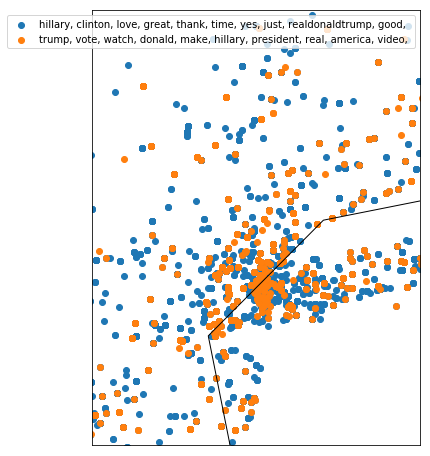

In [26]:
kmeans_plot_map_legend(X, vectorizer, model, df, num_terms=10)

In [27]:
def kmeans_plot_map_legend(matrix, vectorizer, kmeans, lat_lon_df, num_terms=10):
    '''plot sctter plots for different clustering base on kmeans, but also plot the legends as well
    matrix -- a sparse matrix, after you call fit_transform over all_tweets dataframe
    vectorizer -- the vectorizer you used to do fit_transform on all_tweets
    kmeans : kmeans model, should be already fit
    lat_lon_df : a pandas dataframe containing latitudes and longitudes'''
    my_map = Basemap(projection='merc', resolution='c',
                llcrnrlat=28, urcrnrlat=36,
                llcrnrlon=-106, urcrnrlon=-94)
    
    terms = vectorizer.get_feature_names()
    lons, lats = df.lon.values, df.lat.values
    for k in range(kmeans.n_clusters):
        current_lons = lons[ kmeans.labels_ == k ]
        current_lats = lats[ kmeans.labels_ == k ]
        
        legends = ''
        for count, index in enumerate(np.argsort(-kmeans.cluster_centers_[k]) ):
            if count >= num_terms:
                break
            legends += terms[index] + ', '
        
        x, y = my_map(current_lons, current_lats)
        my_map.scatter(x, y, label=legends)
        
    my_map.drawcoastlines()
    my_map.drawcountries()
    plt.legend()

/Users/gabrielacarrillo/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/gabrielacarrillo/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


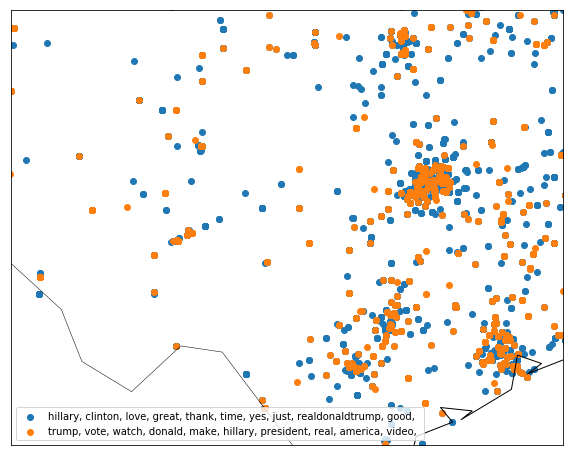

In [28]:
kmeans_plot_map_legend(X, vectorizer, model, df, num_terms=10)

In [35]:
def kmeans_plot_map_legend(matrix, vectorizer, kmeans, lat_lon_df, num_terms=10):
    '''plot sctter plots for different clustering base on kmeans, but also plot the legends as well
    matrix -- a sparse matrix, after you call fit_transform over all_tweets dataframe
    vectorizer -- the vectorizer you used to do fit_transform on all_tweets
    kmeans : kmeans model, should be already fit
    lat_lon_df : a pandas dataframe containing latitudes and longitudes'''
    my_map = Basemap(projection='merc', resolution='c',
                llcrnrlat=42, urcrnrlat=46,
                llcrnrlon=-126, urcrnrlon=-116)
    
    terms = vectorizer.get_feature_names()
    lons, lats = df.lon.values, df.lat.values
    for k in range(kmeans.n_clusters):
        current_lons = lons[ kmeans.labels_ == k ]
        current_lats = lats[ kmeans.labels_ == k ]
        
        legends = ''
        for count, index in enumerate(np.argsort(-kmeans.cluster_centers_[k]) ):
            if count >= num_terms:
                break
            legends += terms[index] + ', '
        
        x, y = my_map(current_lons, current_lats)
        my_map.scatter(x, y, label=legends)
        
    my_map.drawcoastlines()
    my_map.drawcountries()
    plt.legend()

/Users/gabrielacarrillo/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/gabrielacarrillo/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


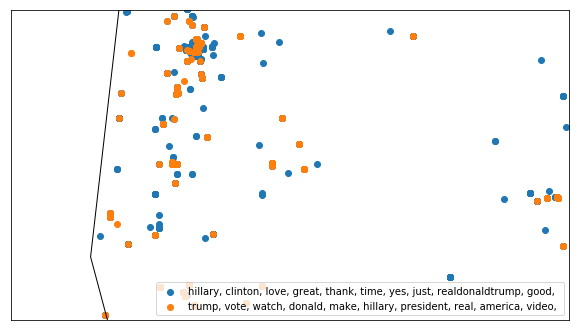

In [36]:
kmeans_plot_map_legend(X, vectorizer, model, df, num_terms=10)